In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# sys.path = ['/data/src/EfficientNet-PyTorch',
#             '/data/src/DeepFake',
#             '/data/src/kaggle_deepfake',
#            ] + sys.path

In [2]:
# libraries
import json
import glob
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr
import albumentations
import matplotlib.pyplot as plt
import seaborn as sns
# import torchcontrib
from apex import amp
from efficientnet_pytorch import model as enet
# from util import wait_for_gpu

# from models import Swish_module, DenseCrossEntropy, ArcFaceLoss, ArcMarginProduct, enet_arcface
from project_tools import project_utils, project_class, project_config, torch_utils

device = torch.device('cuda')

In [3]:
kernel_type = 'hsq01' # saved model name: cls_b0_256_b128_augv1_newdata_adamW_myhead_model
opt_module = optim.AdamW
image_size = 256
cut_size = int(image_size * 0.80)
mean_sub = 0
use_amp = True
data_dir = '/data/data/DeepFake'
enet_type = 'efficientnet-b0'
batch_size = 128
n_skip = 6
n_frames = 20
num_workers = 32
init_lr = 0.0001

freeze_epo = 0
warmup_epo = 1
cosine_epo = 19
n_epochs = freeze_epo + warmup_epo + cosine_epo

# df_train = pd.read_csv(os.path.join(f'../../train.csv'))

In [4]:
stratified_feature = 'group'
train_ratio = 0.95
use_baseline_valid = False
use_baseline_train = False
sample_run = False
sample_size = 10000
sample_valid = False
sample_valid_size = 200000
sample_train = True
sample_train_size = 200000


image_path = '../data/face_extraction_train_images_cv/'
img_df_file = '../data/img_df.pkl'

img_df = project_utils.load_data(img_df_file)

In [5]:
def get_dataframes():
    global img_df, imgage_path, img_df_file, baseline, stratified_feature
    global sample_run, sample_size, sample_valid, sample_valid_size, sample_train, sample_train_size
    global use_baseline_train, use_baseline_valid

    
    true_idx = img_df[img_df['label']==1].index.tolist()
    fake_idx = img_df[img_df['label']==0].sample(len(true_idx)).index.tolist()
    img_df = img_df.loc[(true_idx+fake_idx)].reset_index(drop=True)

    if sample_run:
        img_df = img_df.sample(sample_size).reset_index(drop=True)

    if use_baseline_valid:
        baseline_meta = project_utils.load_data(baseline)
        if 'lvalid' in baseline_meta.keys():
            lval_df = baseline_meta['lvalid']
        else:
            lval_df = baseline_meta['lvalid_df']

        if use_baseline_train:
            ltrain_df = baseline_meta['ltrain_df']
        else:
            original_group_series = pd.Series(img_df[stratified_feature].unique())
            valid_original_groups = lval_df[stratified_feature].unique().tolist()
            train_original_groups = project_utils.list_difference(original_group_series.tolist(), valid_original_groups)
            train_idx = img_df.loc[~img_df[stratified_feature].isin(valid_original_groups)].index.values
            ltrain_df = img_df.iloc[train_idx].copy().reset_index(drop=True)


    else:
        original_group_series = pd.Series(img_df[stratified_feature].unique())
        train_length = int(len(original_group_series) * train_ratio)
        train_original_groups = original_group_series.sample(train_length).tolist()
        valid_original_groups = project_utils.list_difference(original_group_series.tolist(), train_original_groups)

        val_idx = img_df.loc[img_df[stratified_feature].isin(valid_original_groups)].index.values
        train_idx = img_df.iloc[img_df.index.difference(val_idx)].index.values

        ltrain_df = img_df.iloc[train_idx].copy().reset_index(drop=True)
        lval_df = img_df.iloc[val_idx].copy().reset_index(drop=True)

    if sample_train:
        ltrain_df = ltrain_df.sample(sample_train_size).copy().reset_index(drop=True)

    if sample_valid:
        lval_df = lval_df.sample(sample_valid_size).copy().reset_index(drop=True)

    ltrain_vids_count = ltrain_df['original'].nunique()
    lval_vids_count = lval_df['original'].nunique()

    print('train with %d images from %d original videos' % (len(ltrain_df), ltrain_vids_count))
    print('validate with %d images from %d original videos' % (len(lval_df), lval_vids_count))
    print('train label value counts:')
    print(ltrain_df['label'].value_counts())
    print('valid label value counts:')
    print(lval_df['label'].value_counts())
    return ltrain_df, lval_df

df_train, df_valid = get_dataframes()

train with 200000 images from 17884 original videos
validate with 71656 images from 906 original videos
train label value counts:
0    100273
1     99727
Name: label, dtype: int64
valid label value counts:
0    36142
1    35514
Name: label, dtype: int64


In [6]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_pretrained(backbone)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def forward(self, x):
        x = self.enet(x)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                h = self.myfc(dropout(x))
            else:
                h += self.myfc(dropout(x))
        h /= len(self.dropouts)
        return h

In [7]:
class DeepFakeDataset(Dataset):
    def __init__(self, df, split, mode, image_size, mean_sub=0, transform=None):

        self.df = df.reset_index(drop=True)
        self.split = split
        self.mode = mode
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):

        row = self.df.iloc[index]
        file_path = row['abs_file']
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))

        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image = image.astype(np.float32)

        image /= 255
        image = image.transpose(2, 0, 1)

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label = row["label"]
            return torch.tensor(image), torch.tensor(label).float() 

In [8]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.RandomContrast(limit=0.2, p=0.75),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=5),
        albumentations.MedianBlur(blur_limit=5),
        albumentations.GaussianBlur(blur_limit=5),
        albumentations.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.5),

    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.0),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.0),
        albumentations.ElasticTransform(alpha=3),
    ], p=0.7),

#     albumentations.CLAHE(clip_limit=1.0, p=0.7),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
#     albumentations.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=15, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=cut_size, max_w_size=cut_size, num_holes=1, p=0.7),
#     albumentatilons.Resize(352, 544),
])
transforms_val = albumentations.Compose([
#     albumentations.Resize(352, 544)
])

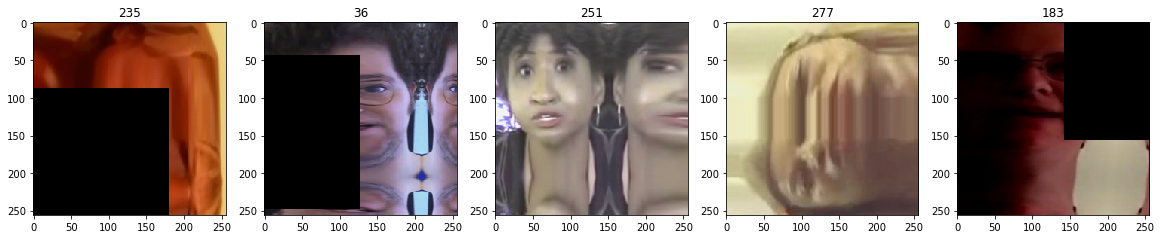

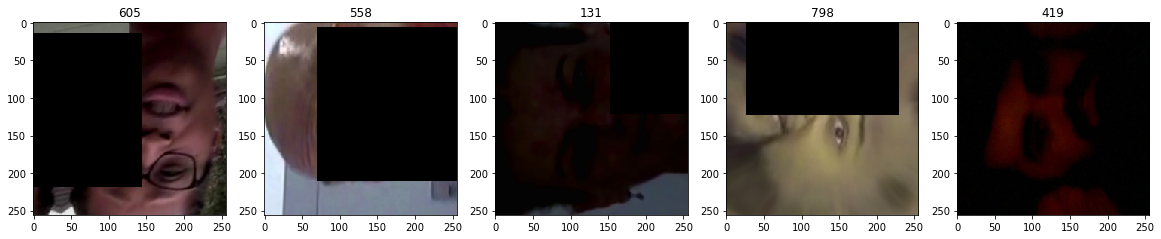

In [9]:
df_show = df_train.iloc[:1000]
dataset_show = DeepFakeDataset(df_show, 'train', 'train', image_size, transform=transforms_train)
# dataset_show = CloudDataset(df_train, 'train', 'val', image_size, transform=None)
# dataset_show = CloudDataset(df_test, 'test', 'test', image_size, transform=None)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(idx)

In [10]:
def criterion(logits, targets):
    loss = nn.BCEWithLogitsLoss()(logits.view(-1), targets.view(-1))
    return loss

In [11]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-20:]) / min(len(train_loss), 20)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    acc = 0.0

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.unsqueeze(-1).to(device)
            logits = model(data)
            LOGITS.append(logits)

            loss = criterion(logits, target)
            val_loss.append(loss.detach().cpu().numpy())

            pred = (logits > 0.5).float()
            acc += (target == pred).sum().cpu().numpy()

        val_loss = np.mean(val_loss)
        acc = acc / len(dataset_valid) * 100

    if get_output:
        LOGITS = torch.cat(LOGITS).cpu().numpy()
        return LOGITS
    else:
        return val_loss, acc

In [ ]:
record = {'train_loss': [], 'val_loss': [], 'val_acc': []}

dataset_train = DeepFakeDataset(df_train, 'train', 'train', image_size=image_size, mean_sub=mean_sub, transform=transforms_train)
dataset_valid = DeepFakeDataset(df_valid, 'train', 'val',   image_size=image_size, mean_sub=mean_sub, transform=transforms_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=None, num_workers=num_workers)

model = enetv2(enet_type, out_dim=1)
model = model.to(device)
#     model.load_state_dict(torch.load(f'{kernel_type}_best_fold{i_fold}.pth'), strict=False)
valid_loss_min = np.inf
save_model_file = f'../models/pytorch/{kernel_type}model.pth'

print('Training All Layers...')
optimizer = opt_module(model.parameters(), lr=init_lr)
if use_amp:
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler_warmup.step(epoch-1)
    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}.'
    print(content)

    if val_loss < valid_loss_min:
        print('val_loss ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, val_loss))
        torch.save(model.state_dict(), save_model_file)
        valid_loss_min = val_loss

    record['train_loss'].append(np.mean(train_loss))
    record['val_loss'].append(val_loss)
    record['val_acc'].append(acc)

# torch.save(model.state_dict(), os.path.join(f'{kernel_type}model.pth'))

Loaded pretrained weights for efficientnet-b0
Training All Layers...
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Tue Apr 28 20:37:45 2020 Epoch: 1



Tue Apr 28 20:48:43 2020 Epoch 1, lr: 0.0001000, train loss: 0.60618, val loss: 0.46515, acc: 76.85330.
val_loss (inf --> 0.465153).  Saving model ...
Tue Apr 28 20:48:43 2020 Epoch: 2


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0




Tue Apr 28 20:59:44 2020 Epoch 2, lr: 0.0010000, train loss: 0.55474, val loss: 0.48997, acc: 74.81439.
Tue Apr 28 20:59:44 2020 Epoch: 3


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0




Tue Apr 28 21:10:45 2020 Epoch 3, lr: 0.0010000, train loss: 0.49419, val loss: 0.49797, acc: 77.69482.
Tue Apr 28 21:10:45 2020 Epoch: 4



Tue Apr 28 21:21:47 2020 Epoch 4, lr: 0.0009729, train loss: 0.46058, val loss: 0.43651, acc: 77.89159.
val_loss (0.465153 --> 0.436508).  Saving model ...
Tue Apr 28 21:21:47 2020 Epoch: 5


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0




Tue Apr 28 21:32:51 2020 Epoch 5, lr: 0.0009397, train loss: 0.43697, val loss: 0.32915, acc: 85.25874.
val_loss (0.436508 --> 0.329146).  Saving model ...
Tue Apr 28 21:32:51 2020 Epoch: 6



Tue Apr 28 21:43:54 2020 Epoch 6, lr: 0.0008946, train loss: 0.41705, val loss: 0.35335, acc: 82.83465.
Tue Apr 28 21:43:54 2020 Epoch: 7


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0




Tue Apr 28 21:55:03 2020 Epoch 7, lr: 0.0008386, train loss: 0.40072, val loss: 0.37521, acc: 80.51803.
Tue Apr 28 21:55:03 2020 Epoch: 8


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0




Tue Apr 28 22:06:12 2020 Epoch 8, lr: 0.0007735, train loss: 0.38381, val loss: 0.35401, acc: 84.27068.
Tue Apr 28 22:06:12 2020 Epoch: 9


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0




Tue Apr 28 22:17:20 2020 Epoch 9, lr: 0.0007008, train loss: 0.36981, val loss: 0.38831, acc: 82.93234.
Tue Apr 28 22:17:20 2020 Epoch: 10



Tue Apr 28 22:28:30 2020 Epoch 10, lr: 0.0006227, train loss: 0.35617, val loss: 0.36880, acc: 83.36217.
Tue Apr 28 22:28:30 2020 Epoch: 11


In [44]:
save_model_file = f'../models/pytorch/{kernel_type}model.pth'
torch.save(model.state_dict(), save_model_file)
